# Physical Dimensions

This notebook attempts to build an ML model for predicting the position of a player given their physical dimensions.

The attributes I've used include (Include rationale for these attributes).

* year_start, year_end

Explanation: NBA Players dimensions have changed drastically over time. Can insert a graph. The year in which a player started playing could inform what position they likely played. 

** Note: Try looking at the players that it misclassified and then classified correctly before including year_start & year_end and after including year_start & year_end.

* height
* weight
* BMI

Data Sources:

* https://www.kaggle.com/datasets/szymonjwiak/nba-active-players-data-images?resource=download: Player headshots and active players
* https://www.basketball-reference.com/leagues/NBA_2023.html: Player statistics (Use it to downlad player statistics up to a certain date + more of it than other doc)

### TODO:

1. See if the all_seasons.csv dataset improves accuracy as it has more data. If yes, could then try adding on data not present in all_seasons.csv (earlier on) to see if it improves accuracy. https://www.kaggle.com/datasets/justinas/nba-players-data
2. Test out different models with evaluation.
3. Build a similarity model that finds the player from the 2022-2023 season with the most similar attributes using active_players.csv.

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pickle

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV

sns.set_theme()
%matplotlib inline

In [2]:
np.random.seed(0)

# Data Preprocessing

In [3]:
# Reading in data
player_attributes = pd.read_csv(os.path.join("data", "Players.csv"))
player_pos = pd.read_csv(os.path.join("data", "player_data.csv"))
active_players = pd.read_csv(os.path.join("data", "active_players.csv"))

In [4]:
player_attributes.head()

,Unnamed: 0,Player,height,weight,collage,born,birth_city,birth_state
0,0,Curly Armstrong,180.0,77.0,Indiana University,1918.0,NaN,NaN
1,1,Cliff Barker,188.0,83.0,University of Kentucky,1921.0,Yorktown,Indiana
2,2,Leo Barnhorst,193.0,86.0,University of Notre Dame,1924.0,NaN,NaN
3,3,Ed Bartels,196.0,88.0,North Carolina State University,1925.0,NaN,NaN
4,4,Ralph Beard,178.0,79.0,University of Kentucky,1927.0,Hardinsburg,Kentucky


In [5]:
player_pos.head()

,name,year_start,year_end,position,height,weight,birth_date,college
0,Alaa Abdelnaby,1991,1995,F-C,6-10,240.0,"June 24, 1968",Duke University
1,Zaid Abdul-Aziz,1969,1978,C-F,6-9,235.0,"April 7, 1946",Iowa State University
2,Kareem Abdul-Jabbar,1970,1989,C,7-2,225.0,"April 16, 1947","University of California, Los Angeles"
3,Mahmoud Abdul-Rauf,1991,2001,G,6-1,162.0,"March 9, 1969",Louisiana State University
4,Tariq Abdul-Wahad,1998,2003,F,6-6,223.0,"November 3, 1974",San Jose State University


### Handling datasets used to predict a players position

As there are two separate dataframe (player_attributes, player_pos) that we'll use for predicting a players position based on physical attributes, we'll combine them into single dataframe that contains the physical dimensions of players along with their position.

In [6]:
# Join player_attributes with player_data to obtain position (response)
player_data = pd.merge(player_attributes, player_pos, how = "inner", left_on = "Player", right_on = "name")

In [7]:
print("Number of observations in player attributes:", len(player_attributes))
print("Number of observations in player positions:", len(player_pos))
print("Number of observations in player data:", len(player_data))

Number of observations in player attributes: 3922
Number of observations in player positions: 4550
Number of observations in player data: 3814


* There are 3922 players that have physical attributes, 4550 players that have positions but only 3814 players who have both physical attributes and positions in this dataset. Clearly, there were either players with no positions, or positional data with no associated player.  

* As an example, the dataframe below shows players without a position.

In [8]:
# Lets explore the players that didn't have a position
full_player_data = pd.merge(player_attributes, player_pos, how = "left", left_on = "Player", right_on = "name")

full_player_data[(full_player_data['position'].isna()) & (~ full_player_data['height_x'].isna())].tail()

,Unnamed: 0,Player,height_x,weight_x,collage,born,birth_city,birth_state,name,year_start,year_end,position,height_y,weight_y,birth_date,college
3351,3307,Luc Mbah,201.0,99.0,NaN,1984.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3591,3544,Nando De,206.0,97.0,NaN,1968.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3775,3727,James Michael,198.0,90.0,NaN,1992.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3870,3822,Walter Tavares,221.0,117.0,NaN,1992.0,Maio,Cape Verde,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3932,3884,Sheldon McClellan,196.0,90.0,University of Miami,1992.0,Houston,Texas,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Next, lets keep only the relevant columns for the Machine Learning models including:

* Dependent Variable (i.e. position)
* Potential Independent Variables (i.e. height, weight, year_start, year_end)
* Player Name

In [9]:
player_data = player_data[['Player', 'height_x', 'weight_x', 'year_start', 'year_end', 'position']]
player_data.rename(columns = {"Player": "player", "height_x": "height", "weight_x": "weight"}, inplace=True)

In [10]:
# Checking the shape, number of duplicates and missing values

print(f'The number of rows in the dataset is: {player_data.shape[0]}')
print(f'The number of columns/features in the dataset is: {player_data.shape[1]}')
print(f'The number of duplicate entries in the dataset is: {player_data.duplicated().sum()}')
print(f'The number of missing values in the dataset is: {player_data.isna().sum().sum()}')

The number of rows in the dataset is: 3814
The number of columns/features in the dataset is: 6
The number of duplicate entries in the dataset is: 1
The number of missing values in the dataset is: 1


In [11]:
# Dropping the duplicate row, and missing value (all attributes required)
player_data.drop_duplicates(inplace = True)
player_data.dropna(inplace=True)

In [12]:
player_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3812 entries, 0 to 3813
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   player      3812 non-null   object 
 1   height      3812 non-null   float64
 2   weight      3812 non-null   float64
 3   year_start  3812 non-null   int64  
 4   year_end    3812 non-null   int64  
 5   position    3812 non-null   object 
dtypes: float64(2), int64(2), object(2)
memory usage: 208.5+ KB


In [13]:
player_data

,player,height,weight,year_start,year_end,position
0,Curly Armstrong,180.0,77.0,1949,1951,G-F
1,Cliff Barker,188.0,83.0,1950,1952,G
2,Leo Barnhorst,193.0,86.0,1950,1954,F-G
3,Ed Bartels,196.0,88.0,1950,1951,F
4,Ralph Beard,178.0,79.0,1950,1951,G
...,...,...,...,...,...,...
3809,Troy Williams,198.0,97.0,2017,2018,F
3810,Kyle Wiltjer,208.0,108.0,2017,2017,F
3811,Stephen Zimmerman,213.0,108.0,2017,2017,C
3812,Paul Zipser,203.0,97.0,2017,2018,G-F


In [14]:
# Check unique positions of positions (categorical)
player_data['position'].value_counts()

position
G      1322
F      1078
C       434
F-C     332
G-F     296
C-F     176
F-G     174
Name: count, dtype: int64

* It's evident that there are a large number of players who have two positions, separated by a dash "-". I will need to handle this situaiton to ensure that each player is associated with one position.

* The possible positions of players should be G (Guard), F (Forward) or C (Center) as these are the broad positions a basketball player could play.

In [15]:
# Observing recent players to identify primary position
player_data[(player_data['year_start'] == 2016) & (player_data['position'].str.contains('-'))].tail()

,player,height,weight,year_start,year_end,position
3713,Jonathon Simmons,185.0,83.0,2016,2018,G-F
3715,Axel Toupane,201.0,89.0,2016,2017,G-F
3716,Karl-Anthony Towns,213.0,110.0,2016,2018,C-F
3717,Myles Turner,211.0,110.0,2016,2018,C-F
3720,Alan Williams,198.0,90.0,2016,2017,F-C


* Through my domain knowledge, it is evident that the position listed prior to the dash "-" is the primary position of a player since players such as Karl-Anthony Towns and Myles Turner are widely regarded as Centers (C) who just so happen to be able to play the Forward (F) position. Another example is Jonathon Simmons who primarily players Guard (G) but is labelled as G-F.
* As a result, I will keep only the primary position of such players.

In [16]:
# Extracting only primary position of each player
player_data['position'] = player_data['position'].apply(lambda row: row[0])

# Checking only primary positions exist
player_data['position'].value_counts()

position
G    1618
F    1584
C     610
Name: count, dtype: int64

### Handling datasets used to predict a similar active NBA player

In [17]:
active_players.head()

,playerid,fname,lname,position,height,weight,birthday,country,school,draft_year,draft_round,draft_number
0,1630173,Precious,Achiuwa,Forward,6-8,225,1999-09-19,Nigeria,Memphis,2020,1.0,20.0
1,203500,Steven,Adams,Center,6-11,265,1993-07-20,New Zealand,Pittsburgh,2013,1.0,12.0
2,1628389,Bam,Adebayo,Center-Forward,6-9,255,1997-07-18,USA,Kentucky,2017,1.0,14.0
3,1630534,Ochai,Agbaji,Guard,6-5,215,2000-04-20,USA,Kansas,2022,1.0,14.0
4,1630583,Santi,Aldama,Forward-Center,7-0,215,2001-01-10,Spain,Loyola-Maryland,2021,1.0,30.0


In [18]:
active_players['weight'] = active_players['weight'].apply(lambda x: x * 0.45359237)

def feet_to_cm(height: str):
    feet, inches = map(int, height.split("-"))
    return (feet * 30.48) + inches * 2.54

active_players['height'] = active_players['height'].apply(feet_to_cm)

In [19]:
# Modify position values to be in consistent format ('G', 'F', 'C')
active_players['position'] = active_players['position'].apply(lambda pos: pos[0])

In [20]:
# Obtaining relevant columns
active_players = active_players.loc[:, 'playerid':'weight']

In [21]:
# Include BMI feature
active_players['BMI'] = active_players['weight'] / (active_players['height']/100)**2
active_players.head()

,playerid,fname,lname,position,height,weight,BMI
0,1630173,Precious,Achiuwa,F,203.20,102.058283,24.717290
1,203500,Steven,Adams,C,210.82,120.201978,27.045063
2,1628389,Bam,Adebayo,C,205.74,115.666054,27.325521
3,1630534,Ochai,Agbaji,G,195.58,97.522360,25.495018
4,1630583,Santi,Aldama,F,213.36,97.522360,21.422897


In [22]:
# Checking the shape, number of duplicates and missing values

print(f'The number of rows in the dataset is: {active_players.shape[0]}')
print(f'The number of columns/features in the dataset is: {active_players.shape[1]}')
print(f'The number of duplicate entries in the dataset is: {active_players.duplicated().sum()}')
print(f'The number of missing values in the dataset is: {active_players.isna().sum().sum()}')

The number of rows in the dataset is: 548
The number of columns/features in the dataset is: 7
The number of duplicate entries in the dataset is: 0
The number of missing values in the dataset is: 0


In [23]:
active_players.head()

,playerid,fname,lname,position,height,weight,BMI
0,1630173,Precious,Achiuwa,F,203.20,102.058283,24.717290
1,203500,Steven,Adams,C,210.82,120.201978,27.045063
2,1628389,Bam,Adebayo,C,205.74,115.666054,27.325521
3,1630534,Ochai,Agbaji,G,195.58,97.522360,25.495018
4,1630583,Santi,Aldama,F,213.36,97.522360,21.422897


# Feature Engineering

Next, I will perform some feature engineering by incorporating the BMI of the player as a feature. The rational behind this decision is that most NBA positions have been increasing in height over time, especially Guards in the NBA which could cause some confusion as certain Guards like Luka Doncic have the heights of an average Forward. The incorporating of BMI captures how "bulky" a player is as most tall guards are generally less "bulky" than a forward of similar height considering the difference in roles between a Guard and Forward. Forwards are generally expected to be better rebounders which requires greater size whereas guards are generally expected to be more agile and shifty which is typically associated with players that are lighter.

**Note:** Show a chart of average height of NBA players over time to prove my point + chart of average weight of each position.

In [24]:
player_data['BMI'] = player_data['weight'] / (player_data['height']/100)**2
player_data.head()

,player,height,weight,year_start,year_end,position,BMI
0,Curly Armstrong,180.0,77.0,1949,1951,G,23.765432
1,Cliff Barker,188.0,83.0,1950,1952,G,23.483477
2,Leo Barnhorst,193.0,86.0,1950,1954,F,23.087868
3,Ed Bartels,196.0,88.0,1950,1951,F,22.907122
4,Ralph Beard,178.0,79.0,1950,1951,G,24.933720


# EDA

## Dimensionality Reduction For Visualisation

In [25]:
# Scale copy of data for dimensionality reduction
scaler = StandardScaler()
dim_player_data = scaler.fit_transform(player_data.drop(['player', 'position'], axis = 1))
dim_player_data = pd.DataFrame(dim_player_data, columns=['height', 'weight', 'year_start', 'year_end', 'bmi'])
dim_player_data['position'] = player_data.reset_index()['position']

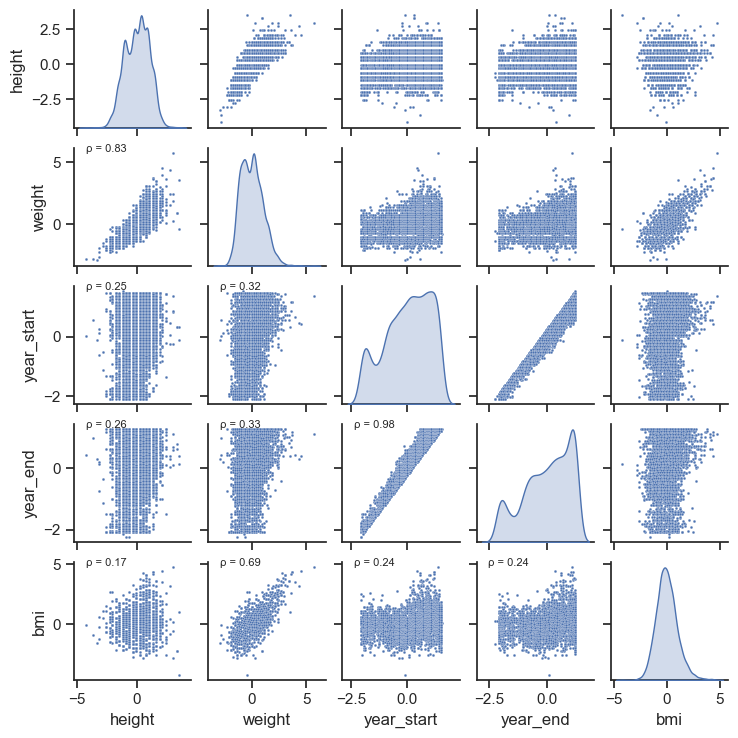

In [26]:
# Scatterplot matrix
from scipy.stats import pearsonr

def corrfunc(x, y, ax=None, **kws):
    """Plot the correlation coefficient in the top left hand corner of a plot."""
    r, _ = pearsonr(x, y)
    ax = ax or plt.gca()
    ax.annotate(f'ρ = {r:.2f}', xy=(.1, .965), xycoords=ax.transAxes, fontsize = 8)

with sns.axes_style(style = 'ticks'):
    spm = sns.pairplot(data=dim_player_data,
                height=1.5,
                plot_kws={"s": 4},
                diag_kind="kde",
                )
    spm.map_lower(corrfunc)

**Observations:**

* The presence of some relatively **strong linear relationships** such as between (weight & bmi), (year_start & year_end) and (weight & height) which supports the use of PCA for dimensionality reduction.
* The presence of a **relatively large number of non linear relationships** primarily between year_start, year_end and the other variables. This suggests that height, weight and bmi of NBA players have generally not changed over time which could cause PCA to be less effective compared to non-linear dimensionality reduction techniques. Furthermore, the plot between (bmi & height) appears to show a deterministic association. As a result, I will try both PCA and non-linear dimensionality techniques including t-SNE and UMAP.
* The presence of a **few drastic outliers** which may need to be removed as the direction of outliers typically have a larger variance.

The above two are used to check whether there are any potential issues for PCA, such as skewness, outliers, clustering or non-linear dependencies.

Example: Data is strongly elliptical in most projections, suggesting there is one primary direction of variation in the data, with only small variation in any direction away from it.

### PCA

In [27]:
# Compute PCA
pca = PCA(n_components=2)
projected_data = pca.fit_transform(dim_player_data.drop('position', axis = 1))

In [28]:
def plot_dim_reduction(df, xlabel: str, ylabel: str, title: str, colors: list, handles: list):
    """
     Function to plot PC
    """
    plt.figure(figsize=(10,6))
    plt.scatter(
        x = df[:, 0],
        y = df[:, 1],
        c = colors,
        alpha = 0.5
    )

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend(handles=handles, title='Positions', handlelength=0.7, loc='upper left', prop={'size':9})

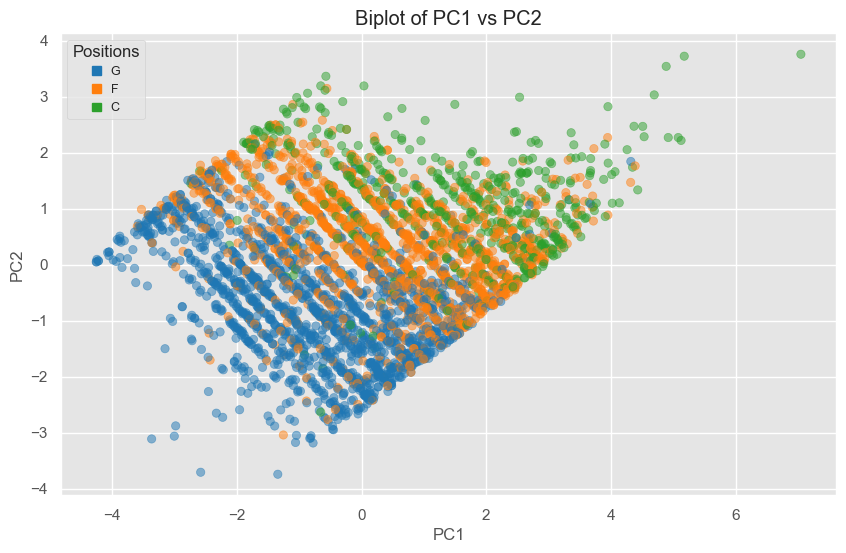

In [29]:
# Data in the model space (2 PC) to see if there is noticeable separation
# Clearly not

# Plot the first two PCs to learn more about the data
levels, categories = pd.factorize(dim_player_data['position'])
colors = [plt.cm.tab10(i) for i in levels] # using the "tab10" colormap
handles = [matplotlib.patches.Patch(color=plt.cm.tab10(i), label=c) for i, c in enumerate(categories)]

with plt.style.context('ggplot'):
    plot_dim_reduction(projected_data, "PC1", "PC2", "Biplot of PC1 vs PC2", colors, handles)

**Observations:**

* The above plot of PC1 vs PC2 shows that there is generally some distinction between the Guards, Forwards and Centers but it is clear that there is still a relatively large amount of overlap between the data points, likely due to the large amount of NBA players who have the skillset of a particular position (and are listed as such) but have the size of another position.
* From this, a more complicated model may perform better at classifying positions.

### T-SNE

In [30]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2)
tsne_data = tsne.fit_transform(dim_player_data.drop('position', axis = 1))

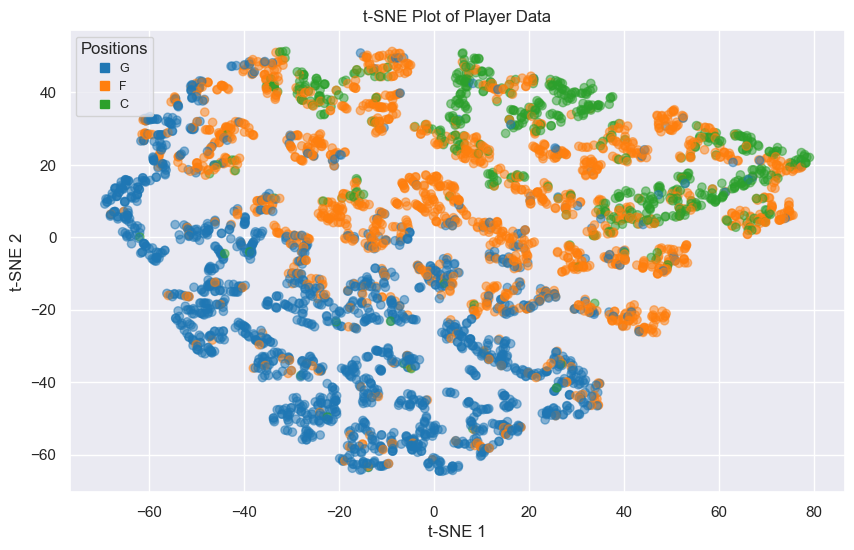

In [31]:
plot_dim_reduction(tsne_data, "t-SNE 1", "t-SNE 2", "t-SNE Plot of Player Data", colors, handles)

**Observations:**

* Once again, there are three distinctive clusters with Guards, Forwards and Centers. However, there is not much, if any separation between them.
* There are a large number of clusters within each group (i.e. Guards, Forwards and Centers). For example, there appears to be two large, separate groups Centers which overlap with the Forwards. This behaviour is typical of t-SNE and not what I'm looking for.

Perhaps UMAP will do a better job at visualisation.

### UMAP

In [32]:
import umap
import matplotlib.pyplot as plt

# Assuming you have a dataset X
reducer = umap.UMAP(n_components=2)
umap_data = reducer.fit_transform(dim_player_data.drop('position', axis = 1))

/Users/danielliu/anaconda3/envs/positionn/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


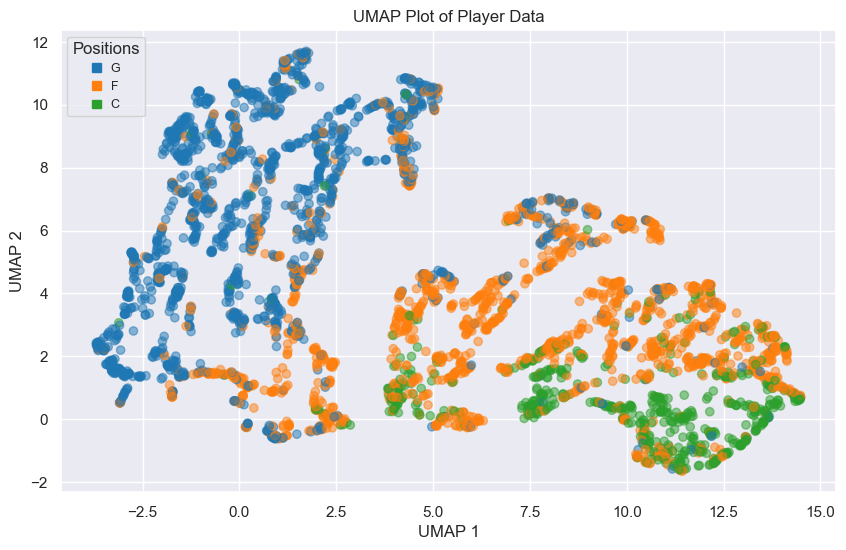

In [33]:
plot_dim_reduction(umap_data, "UMAP 1", "UMAP 2", "UMAP Plot of Player Data", colors, handles)

**Observations:**

* There is a clear distinction between a majority of the Guard observations and the Forward/Center observations, with a small amount of Forwards on the border of Guard observations.
* There is less separation between the Forwards and Centers, but still a noticeable degree to the point where you can visually see the different clusters.

**Comparison between PCA vs NLDR:**

* When comparing PCA and Non-Linear Dimensionality Reduction (NLDR) techniques, it's clear that NLDR visualisations shows more separate and distinct clusters which supports the usage of simpler models being sufficient to capture the differences between classes relatively well. It may be more appropriate to use NLDR techniques considering the large number of non-linear relationships observed in the scatterplot matrix.

**Comparison between t-SNE and UMAP:**

* t-SNE primarily focuses on local structures, meaning it attempts to maintain the relative distances between nearby points (intracluster distances) which may distort the relative distances between clusters (intercluster distances). This may cause t-SNE to blow up smaller distances between closer clusters to show the differences and reduce distances between farther clusters which is evident through the large number of smaller clusters within the Guard, Forward and Center groups.

* UMAP attempts to find a balance between preserving local and global structures, providing a more balanced view of the data. This means that the inter-cluster relationships are generally more meaningful in UMAP visualisations as separation between clusters would likely represent more genuine separation in the data, especially compared to the t-SNE visualisations.

Overall, I will use UMAP to visualise the high-dimensional data as I'm interested in whether the classes are distinguishable from one another in high dimension which focuses on inter-cluster separation. From the UMAP visualisation, I found that:

* There appears to be a reasonable distinction between the three positions, especially between Guards and the other two positions. Furthermore, there was a noticeable distinction between Forwards and Center but it was less separation when compared to the Guards.
* The degree of separation between groups suggests the use of a relatively simple/moderate complexity model may be sufficient.

# Building ML Model

In [34]:
# Obtain predictors and response
player_predictors = player_data.drop(['player', 'position'], axis = 1)
player_response = player_data['position']

# Convert into 2D array with shape (n, 1)
player_response = np.array(player_response).reshape(-1, 1)

# Encode player response to be numeric
ohe = OneHotEncoder(sparse=False, categories='auto')
enc_player_response = ohe.fit_transform(player_response)

# Obtain training/test split
X_train, X_test, y_train, y_test = train_test_split(player_predictors,
                                                    enc_player_response,
                                                    train_size=0.75)

/Users/danielliu/anaconda3/envs/positionn/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


### Trying different models & Evaluation

Encoding output labels as 0, 1, 2 for Classification Report.

* Note: May need to leave it as it is for RF.

Interpretation: 

* https://www.kaggle.com/code/parulpandey/analysing-machine-learning-models-with-yellowbrick
* https://medium.com/apprentice-journal/evaluating-multi-class-classifiers-12b2946e755b

In [35]:
# Obtain predictors and response
relabel_response = {'position': {'G': 0, 'F': 1, 'C': 2}}
relabelled_player_data = player_data.replace(relabel_response)
player_predictors = relabelled_player_data.drop(['player', 'position'], axis = 1)
player_response = relabelled_player_data['position']

# Obtain training/test split
X_train, X_test, y_train, y_test = train_test_split(player_predictors,
                                                    player_response,
                                                    train_size=0.75)

/var/folders/wp/b15fgf414nn0z0y1npgy6lfm0000gq/T/ipykernel_8781/353978947.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  relabelled_player_data = player_data.replace(relabel_response)


In [ ]:
# select classifiers 

#Visualizers
from yellowbrick.classifier import ClassificationReport
from yellowbrick.classifier import ClassPredictionError
from yellowbrick.classifier import ConfusionMatrix
from yellowbrick.classifier import ROCAUC
from yellowbrick.classifier import PrecisionRecallCurve
import matplotlib.pyplot as plt

#Classifiers
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

classifiers=[
DecisionTreeClassifier(max_depth = 2),
SVC(kernel = 'linear', C = 1),
GaussianNB(),
KNeighborsClassifier(n_neighbors = 7),
LogisticRegression(random_state=0, multi_class='multinomial', solver='newton-cg')]

In [ ]:
#obtain class labels for future use 
classes = player_data['position'].value_counts().index.tolist()
classes

In [ ]:
#Write function for class-centric metrics
classes = player_data['position'].value_counts().index.tolist()

# Classification report
def CR_viz():
    def Class_report(model,classes):
        visualizer = ClassificationReport(model, classes=classes, support=True)
        visualizer.fit(X_train, y_train)  # Fit the visualizer and the model
        visualizer.score(X_test, y_test)  # Evaluate the model on the test data
        return visualizer.show()
    for name in classifiers:
        ax = plt.subplot(1,1,1)
        Class_report(name,classes)

In [ ]:
# Compare Accuracy



In [ ]:
CR_viz()

In [ ]:
#Class Prediction Error
def CPE_viz():    
    def CPE(model,classes):
        visualizer = ClassPredictionError(model, classes=classes)
        visualizer.fit(X_train, y_train)  # Fit the visualizer and the model
        visualizer.score(X_test, y_test)  # Evaluate the model on the test data 
        return visualizer.show()  
    for name in classifiers:
        ax = plt.subplot(1,1,1)
        CPE(name,classes)

CPE_viz()

In [ ]:
#Confusion matrix
def CM_viz():    
    def CM(model,classes):
        visualizer = ConfusionMatrix(model, classes=classes,percent=True)
        visualizer.fit(X_train, y_train)  # Fit the visualizer and the model
        visualizer.score(X_test, y_test)  # Evaluate the model on the test data 
        return visualizer.show()  
    for name in classifiers:
        ax = plt.subplot(1,1,1)
        CM(name,classes)
        
CM_viz()

### Best Model: Random Forest

In [ ]:
rfc_pipeline = make_pipeline(StandardScaler(),
                             RandomForestClassifier(n_estimators=500, 
                                                    random_state=0))

# Define dictionary of {'param': [values_to_try]} with __ for pipeline
param_grid = {
    'randomforestclassifier__max_depth': [10, 20, 25],
    'randomforestclassifier__min_samples_leaf': [3, 4, 5, 6],
    'randomforestclassifier__bootstrap': [True, False]
}

rfc_grid = GridSearchCV(estimator=rfc_pipeline,
                    param_grid=param_grid,
                    cv = 3,
                    refit=True,
                    n_jobs = -1
                    )

rfc_grid.fit(X_train, y_train)

In [ ]:
rfc_grid.best_params_

In [ ]:
# Accuracy
y_pred = rfc_grid.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)

In [ ]:
# Transform back to obtain prediction
y_pred = rfc_grid.predict(X_test)
ohe.inverse_transform(y_pred[2].reshape(1, 3))

# Evaluation of Model(s)

Confusion Matrix for Accuracy, Sensitivity, Specificity, Recall.

Find the best model and use that.

# Retrain model on full dataset

Finally, I will retrain the model on the full dataset (training & validation sets) to help the model learn from as much data as possible.

In [ ]:
# Export model
# pickle.dump(rfc_pipeline, open(os.path.join("models", "dimensions_rf.sav"), "wb"))
# pickle.dump(ohe, open(os.path.join("models", "ohe.sav"), "wb"))

# Testing Player Similiarity Model

The model that finds the most similar active NBA player is in `similar_player_dimensions.py`

In [37]:
# Make a prediction with player similarity model
from similar_player_dimensions import SimilarPlayerDimensions
similar_player = SimilarPlayerDimensions(active_players)
similar_player.predict_similar_player(183, 81, 24.18, 'G')

/Users/danielliu/anaconda3/envs/positionn/lib/python3.12/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/Users/danielliu/Desktop/Dev/positionn/similar_player_dimensions.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  active_pos_players['cosine_similarity'] = np.squeeze(cosine_res)


,playerid,fname,lname,position,height,weight,BMI,cosine_similarity
388,1626166,Cameron,Payne,G,185.42,83.007404,24.143692,0.999683


# Obtaining Predictions

In [ ]:
model = pickle.load(open(os.path.join("models", "dimensions_rf.sav"), "rb"))
ohe = pickle.load(open(os.path.join("models", "ohe.sav"), "rb"))

In [ ]:
height = 200.00
weight = 100.00
year_start = 1950
year_end = 1970

# [height, weight, year_start, year_end, bmi] is the required format
tmp_input = np.array([[height, weight, year_start, year_end, (weight / (height/100)**2)]])

In [ ]:
model.predict(tmp_input)

In [ ]:
ohe.inverse_transform(model.predict(tmp_input))

In [ ]:
height = 190
weight = 102
year_start = 2000
year_end = 2001
tmp_input = np.array([[height, weight, year_start, year_end, (weight / (height/100)**2)]])

In [ ]:
model.predict(tmp_input)

In [ ]:
ohe.inverse_transform(model.predict(tmp_input))[0][0]

**Note:** The above shows the importance of having a model that predicts with year_start and year_end. You'd be considered a center during your playing time if you were between 1950-1970 but now, it's Forward!!! Perhaps try to show some chart for this.